In [1]:
import wntr
from scripts.segment import *
from scripts.valves import *
from scripts.utils import *
from scripts.optimization import *
import matplotlib.pyplot as plt

from pylab import rcParams
import pandas as pd
# from scripts.bundle_analysis import *
# from scripts.plot_utils import *
import seaborn as sns
sns.set(font_scale=1.25,rc={"lines.linewidth": 2})
sns.set_style("white")

# Load the network

/home/rewu/Documents/research/valves/wntr/epanet/io.py:2173: UserWarning: Not all curves were used in "./data/hill.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


(<matplotlib.collections.PathCollection at 0x7f644f58d350>,
 <matplotlib.collections.LineCollection at 0x7f644bbbac10>)

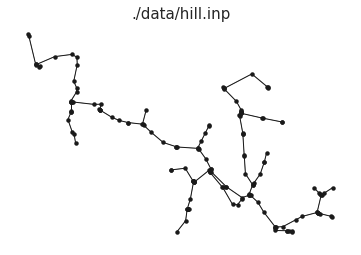

In [2]:
# Create a water network model
inp_file = './data/hill.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.minimum_pressure = 3.5
wn.options.hydraulic.required_pressure = 21

sim = wntr.sim.EpanetSimulator(wn)
init_result = sim.run_sim()
wntr.graphics.plot_network(wn, title=wn.name)

In [3]:
nname2nid = {}
nid2nname = {}
nid2lid = {}

for nid,nname in enumerate(wn.node_name_list):
    nname2nid[nname] = nid
    nid2nname[nid] = nname
    nid2lid[nid] = []
    
lid2nids = {}
lname2lid = {}
lid2lname = {}


for lid,pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    n1_name = pipe.start_node_name
    n2_name = pipe.end_node_name
    lname2lid[pipe.name] = lid
    lid2lname[lid] = pipe.name
    
    nid1,nid2 = nname2nid[n1_name],nname2nid[n2_name]
    lid2nids[lid] = (nid1,nid2)
    
    nid2lid[nid1].append(lid)
    nid2lid[nid2].append(lid)
    
    
pids = list(lid2lname.keys())
# Exclude pipes near sources for simulation proposes
src_pids = [lname2lid['2254665'],lname2lid['8925'],lname2lid['2182239'],
           lname2lid['9440'],lname2lid['8929'],lname2lid['P11']]
src_nids = [nname2nid['ROUND_HILL_FGN']]
valid_pids = list(set(pids)-set(src_pids))
    
# pipe_adj_mtx = assemble_pipe_adj_mtx(nid2lid)
# pipe_data = get_pipe_df(wn)

TOT_LENGTH = 0
for pipe_name in wn.pipe_name_list:
    pipe = wn.get_link(pipe_name)  
    TOT_LENGTH+= pipe.length

In [4]:
# construct pipe demand map
pid2pcost = {}
for nname, item in init_result.node['demand'].items():
#     demand = m3togal(item.values[0])*60 #gal/minute
    demand = item.values[0]
    nid = nname2nid[nname]
    pids = nid2lid[nid]
    for pid in pids:
        if demand >0:
            pid2pcost[pid] = demand/len(pids)
        else:
            pid2pcost[pid] = 0 

# Get the current valve state 

In [5]:
valve_layer = pd.read_csv('./data/valve_layer_hill.csv')
lnames = list(valve_layer['link'])
nnames = list(valve_layer['node'])

valid_nidpids = []
for nname, lname in zip(nnames,lnames):
    nid = nname2nid[nname]
    pid = lname2lid[str(lname)]
    valid_nidpids.append((nid,pid))

valid_nidpids = list (set(valid_nidpids))
print (f'number of valves {len(valid_nidpids)}')

number of valves 48


In [6]:
# add control valves 
src_control_valves = []
for src_pid in src_pids:
    nids = lid2nids[src_pid]
    for nid in nids:
        src_control_valves.append((nid,src_pid))

# Valve Placement Optimization

In [7]:
reg = create_valvereg(lid2nids)
N_nidpids = get_N_nidpids(reg)
N1_nidpids = get_N1_nidpids(reg)
N1_nidpids = set(N1_nidpids)-set(src_control_valves)

In [8]:
# GLOB_SEG_IMPACT_DICT = read_impact_dict()
GLOB_SEG_IMPACT_DICT = {}
vstate = create_valvestates(lid2nids,N1_nidpids,src_control_valves)
segnet = HydroSegmentNet(vstate,src_pids,pid2pcost)

## Start the Optimization Process

In [9]:
init_impacts = init_remove_impacts(wn,segnet,GLOB_SEG_IMPACT_DICT,
                                   lid2lname,nid2nname,
                                  lname2lid,nname2nid,lid2nids)
merge_impacts0 = init_merge_impacts(wn,segnet.vstates.normal_valves,
                                    segnet,GLOB_SEG_IMPACT_DICT,
                                   lid2lname,nid2nname,
                                   lname2lid,nname2nid,lid2nids)

/home/rewu/Documents/research/valves/scripts/bundle_analysis.py:121: RuntimeWarning: invalid value encountered in true_divide
  val_diff_ratio = val_diff/init_val*100


In [10]:
num_valve2remove = len(N1_nidpids) - len(valid_nidpids)
segnet,cum_dirloss,cum_indirloss = valve_optimal_removal(wn,segnet,GLOB_SEG_IMPACT_DICT,num_valve2remove,
                                                        lid2lname,nid2nname,lname2lid,nname2nid,lid2nids)

remove 0 valve with loss 0.0
updating 1 segments
remove 1 valve with loss 0.0
updating 1 segments
remove 2 valve with loss 0.0
updating 1 segments
remove 3 valve with loss 0.0
updating 1 segments
remove 4 valve with loss 0.0
updating 1 segments
remove 5 valve with loss 0.0
updating 1 segments
remove 6 valve with loss 0.0
updating 0 segments
remove 7 valve with loss 5.401837421023823e-12
updating 2 segments
remove 8 valve with loss 1.5005381891853155e-11
updating 2 segments
remove 9 valve with loss 8.135525505739917e-11
updating 2 segments
remove 10 valve with loss 8.942281636905791e-11
updating 2 segments
remove 11 valve with loss 1.2258483538487797e-10
updating 2 segments
remove 12 valve with loss 1.27807695990106e-10
updating 2 segments
remove 13 valve with loss 1.6059928784701444e-10
updating 2 segments
remove 14 valve with loss 1.815561485487718e-10
updating 2 segments
remove 15 valve with loss 1.8656375233357888e-10
updating 2 segments
remove 16 valve with loss 2.4042046477744275e

In [11]:
optimal_risk = evaluate_network_risk(segnet,GLOB_SEG_IMPACT_DICT)
optimal_risk

(1.2424481932021565, 5.781922488973259)

In [12]:
opt_nidpids = []
for valve in segnet.vstates.normal_valves:
    opt_nidpids.append((valve.nid,valve.pid))
len(opt_nidpids)

48

In [ ]:
# import pickle
# with open('./results/rh_opt_valves', 'wb') as fp:
#     pickle.dump(opt_nidpids, fp)


## Compare with other valving strategies

In [ ]:
vstate = create_valvestates(lid2nids,N1_nidpids,src_control_valves)
segnet_n1 = HydroSegmentNet(vstate,src_pids,pid2pcost)
best_risk = evaluate_network_risk(segnet_n1,GLOB_SEG_IMPACT_DICT)
init_dirloss,init_indirloss = best_risk
best_risk

In [ ]:
vstate = create_valvestates(lid2nids,valid_nidpids,src_control_valves)
segnet_curr = HydroSegmentNet(vstate,src_pids,pid2pcost)
impact_dict = {}
init_impacts = init_remove_impacts(wn,segnet_curr,impact_dict,
                                   lid2lname,nid2nname,
                                  lname2lid,nname2nid,lid2nids)
curr_risk = evaluate_network_risk(segnet_curr,impact_dict)
curr_risk

# Add new valves to the current system 

In [ ]:
import copy 
N1_nidpids_large = copy.deepcopy(N1_nidpids)
N1_nidpids_large.update(set(valid_nidpids))

In [ ]:
fixed_valves = valid_nidpids+src_control_valves
vstate = create_valvestates(lid2nids,N1_nidpids_large,fixed_valves)
segnet = HydroSegmentNet(vstate,src_pids,pid2pcost)

In [ ]:
num_valve2remove = len(N1_nidpids_large) - len(valid_nidpids)
segnet,cum_dirloss_added,cum_indirloss_added = valve_optimal_removal(wn,segnet,GLOB_SEG_IMPACT_DICT,num_valve2remove,
                                                                    lid2lname,nid2nname,lname2lid,nname2nid,lid2nids)

In [ ]:
curr_risk_opt = evaluate_network_risk(segnet,GLOB_SEG_IMPACT_DICT)
curr_risk_opt

In [ ]:
# constrained optimization 
dirloss_added = get_loss(init_dirloss,cum_dirloss_added)
indirloss_added = get_loss(init_indirloss,cum_indirloss_added)

# unconstrained optimization 
dirloss = get_loss(init_dirloss,cum_dirloss)
indirloss = get_loss(init_indirloss,cum_indirloss)


In [ ]:
remained_valves_opt = len(N1_nidpids) - np.array(range(len(dirloss)))
tot_loss = dirloss+indirloss

remained_valves_add = len(N1_nidpids_large) - np.array(range(len(dirloss_added)))
tot_loss_add = dirloss_added+indirloss_added
plt.plot(remained_valves_add[-100:],tot_loss_add[-100:],label = 'Added' )
plt.plot(remained_valves_opt[-100:],tot_loss[-100:],linestyle = 'dashed',label = 'Lower Bound')

# plt.plot(dirloss,label = 'Direct Risk',linestyle = 'dashed')
# plt.plot(indirloss,label = 'Indirect Risk',linestyle = 'dashdot')

plt.legend()
plt.xlabel('Number of Installed Valves')
plt.ylabel('Total System Risk (GPM)')
# plt.savefig("opt_figures/round_hill/cum_risk_cmp_rh.png",bbox_inches='tight',dpi=300)

In [ ]:
n = len(remained_valves_opt)
diff = tot_loss_add[-n:]-tot_loss
added_valves = remained_valves_opt - remained_valves_opt[-1]
plt.plot(added_valves,diff,label = 'Risk Diff')
plt.legend()
plt.xlabel('Number of Added Valves')
plt.ylabel('Risk Difference (GPM)')
# plt.savefig("opt_figures/round_hill/cum_risk_diff_rh.png",bbox_inches='tight',dpi=300)



In [ ]:
# Store the intermediate data
fixed_valves = valid_nidpids+src_control_valves
vstate = create_valvestates(lid2nids,N1_nidpids_large,fixed_valves)
segnet_inter = HydroSegmentNet(vstate,src_pids,pid2pcost)

num_valve2remove = len(N1_nidpids_large) - len(valid_nidpids) - 20 
segnet_inter,cum_dirloss_inter,cum_indirloss_inter = valve_optimal_removal(wn, segnet_inter,GLOB_SEG_IMPACT_DICT,num_valve2remove,
                                                                          lid2lname,nid2nname,lname2lid,nname2nid,lid2nids)


In [ ]:
added_nidpids = []
for valve in segnet_inter.vstates.normal_valves:
    if (valve.nid,valve.pid) in fixed_valves:
        continue 
    added_nidpids.append((valve.nid,valve.pid))
print(len(added_nidpids))

# import pickle
# with open('./results/rh_added_valves', 'wb') as fp:
#     pickle.dump(added_nidpids, fp)



# Robustness Estimation 

In [27]:
from scripts.utils1 import * 
from scripts.bundle_analysis import * 
from scripts.damage_estimation import * 


In [47]:
# opt valves 
fail_rates = [0.1,0.2,0.3,0.4,0.5]
num_steps = 50
GLOB_SEG_IMPACT_DICT = {}
save_path = './data/simulation_progress/rh_opt'
damage_list_opt = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                                   src_pids,src_nids,pid2pcost,
                     GLOB_SEG_IMPACT_DICT,opt_nidpids,fail_rates,src_control_valves,
                                       num_steps = num_steps,save_path = save_path)

number of segment to simulate: 45
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 10


/home/rewu/Documents/research/valves/scripts/bundle_analysis.py:121: RuntimeWarning: invalid value encountered in true_divide
  val_diff_ratio = val_diff/init_val*100


number of segment to simulate: 4
number of segment to simulate: 4
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of 

number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
dict saved
result saved


In [48]:
# deployed valves 
save_path = './data/simulation_progress/rh_default'
damage_list_current = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                                   src_pids,src_nids,pid2pcost,
                     GLOB_SEG_IMPACT_DICT,valid_nidpids,fail_rates,src_control_valves,
                                       num_steps = num_steps,save_path = save_path)

number of segment to simulate: 35
number of segment to simulate: 11
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 3
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 3
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number o

number of segment to simulate: 0
number of segment to simulate: 2
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 3
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 3
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 3
number of segment to simulate: 0
number of segment to simulate: 2
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 2
number of segment to simulate: 2
Issues when running hydrualic simulation, use the initial result
number of segment to simulate: 1
dict saved
result saved


In [49]:
# n1
save_path = './data/simulation_progress/rh_n1'
damage_list_n1 = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                                   src_pids,src_nids,pid2pcost,
                     GLOB_SEG_IMPACT_DICT,N1_nidpids,fail_rates,src_control_valves,
                                       num_steps = num_steps,save_path = save_path)

number of segment to simulate: 125
number of segment to simulate: 32
number of segment to simulate: 6
number of segment to simulate: 12
number of segment to simulate: 10
number of segment to simulate: 5
number of segment to simulate: 8
number of segment to simulate: 6
number of segment to simulate: 6
number of segment to simulate: 3
number of segment to simulate: 5
number of segment to simulate: 5
number of segment to simulate: 4
number of segment to simulate: 3
number of segment to simulate: 7
number of segment to simulate: 4
number of segment to simulate: 5
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 6
number of segment to simulate: 3
number of segment to simulate: 5
number of segment to simulate: 2
number of segment to simulate: 4
number of segment to simulate: 4
number of segment to simulate: 3
number of segment to simulate: 1
number of segment to simulate: 3
number of segment to simulate: 3
number of segment to simulate: 2
numbe

number of segment to simulate: 2
number of segment to simulate: 3
number of segment to simulate: 3
number of segment to simulate: 4
dict saved
result saved


In [50]:
# n
save_path = './data/simulation_progress/rh_n'
damage_list_n = evaluate_damages(wn,lid2lname,nid2nname,lname2lid,nname2nid,lid2nids,
                                   src_pids,src_nids,pid2pcost,
                     GLOB_SEG_IMPACT_DICT,N_nidpids,fail_rates,src_control_valves,
                                       num_steps = num_steps,save_path = save_path)

number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of segment to simulate: 0
number of 

number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 1
number of segment to simulate: 0
number of segment to simulate: 2
number of segment to simulate: 2
dict saved
result saved


In [52]:
sim_results = [damage_list_n,damage_list_n1,damage_list_opt,damage_list_current]
valving_types = ['N','N1','Proposed','Deployed']
res_dfs = []
for res,vtype in zip(sim_results,valving_types):
    df = summarize2df(res,fail_rates,vtype)
    res_dfs.append(df)
summary_df = pd.concat(res_dfs,ignore_index = True)

In [53]:
deployed_df = summary_df[summary_df['Type'].isin(['Proposed'])]
rates = np.array(fail_rates) *100

medians_direct = []
for rate in rates.astype(int):
    selected_df = deployed_df[deployed_df['Fail Rate (%)']==rate]
    medians_direct.append(round(selected_df['Indirect Risk'].std(),2))
medians_direct = np.array(medians_direct)
medians_direct

array([12.37, 12.48, 21.91, 18.54, 16.7 ])

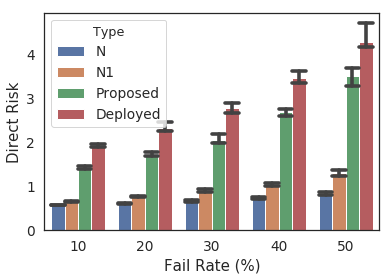

In [54]:
from numpy import median
ax = sns.barplot(x="Fail Rate (%)", y="Direct Risk", hue='Type',
                 data=summary_df, estimator=median,capsize=.2)
# plt.savefig("opt_figures/round_hill/direct_risk_progress_rh.png",bbox_inches='tight',dpi=300)

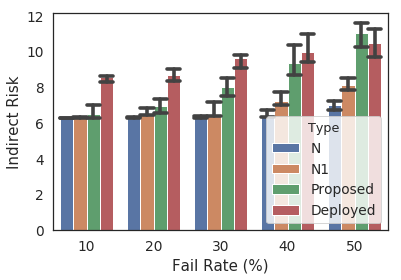

In [55]:
from numpy import median
ax = sns.barplot(x="Fail Rate (%)", y="Indirect Risk", hue='Type',
                 data=summary_df, estimator=median,capsize=.2)
# plt.savefig("opt_figures/round_hill/indirect_risk_progress_rh.png",bbox_inches='tight',dpi=300)
